In [5]:
# implementing OPE of the IPWLearner using synthetic bandit data
from sklearn.linear_model import LogisticRegression
# import open bandit pipeline (obp)
from obp.dataset import SyntheticBanditDataset, logistic_reward_function, SyntheticBanditDatasetWithActionEmbeds
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM,
    DoublyRobust as DR,
    ReplayMethod as RM,
    SelfNormalizedInverseProbabilityWeighting as SNIP
)

from src.custom_estimators import (
    NaiveMethod as NW,
    ReplayProbabilistic as RP,
    MAP
)
from obp.utils import softmax, check_array, check_scalar, sample_action_fast
from src.custom_estimators import compute_groundtruth_reward

import numpy as np
from copy import deepcopy
from typing import Union
import scipy
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# (1) Generate Synthetic Bandit Data
dataset = SyntheticBanditDataset(n_actions=10, 
                                 dim_context=3,
                                 reward_type="binary", 
                                 reward_function=logistic_reward_function, 
                                 beta=-20)
bandit_feedback = dataset.obtain_batch_bandit_feedback(n_rounds=1000)

In each round of simulation, the follow things happen:
1. A context vector, $\tilde{x}$, of length `dim_context` is sampled from normal distribution.
2. For each action vector, $\tilde{a} \in A$, the expected reward $q(x,a)$ is computed as:
    $$
    q(x,a) := \tilde{x}^T M_{X,A} \tilde{a} + \theta_x^T \tilde{x} + \theta_a^T \tilde{a}
    $$

    where $M_{X,A} \in \mathbb{R}^{d_X \times d_A}, \theta_x \in \mathbb{R}^{d_X}, \theta_a \in \mathbb{R}^{d_A}$ are parameter matrix and vectors, all sampled from the uniform distribution. 
    If `action_context` argument is None, then action vector is a one-hot representation.
3. An action is selected based on a behavior policy given by `behavior_policy_function`. If `behavior_policy_function` is None, then behavior policy will be generated by applying the softmax function to the expected reward, which is amplified by `beta`. More specifically,

    $$
    \pi(x, a) = \frac{e^{\beta \times q(x,a)}}{\sum_{a' \in A}e^{\beta \times q(x,a')}}
    $$

    Thus, the optimality of the behavior policy can be controlled by adjusting `beta` parameter. A large value leads to a near-deterministic behavior policy, while a small value leads to a near-uniform behavior policy. A positive value leads to a near-optimal behavior policy, while a negative value leads to a sub-optimal behavior policy.

In [7]:
bandit_feedback.keys() #['action_context']

dict_keys(['n_rounds', 'n_actions', 'context', 'action_context', 'action', 'position', 'reward', 'expected_reward', 'pi_b', 'pscore'])

In [8]:
# (2) Off-Policy Learning
eval_policy = IPWLearner(n_actions=dataset.n_actions, base_classifier=LogisticRegression())
eval_policy.fit(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
    pscore=bandit_feedback["pscore"]
)
action_dist = eval_policy.predict(context=bandit_feedback["context"])

In [9]:
eval_policy.predict_proba(context=bandit_feedback["context"])[:,:,0].shape

(1000, 10)

{'ipw': 1.4282995945813337, 'snipw': 0.7418994937409237, 'nm': 0.361, 'rm': 0.3728813559322034, 'dr': 0.5752361010974041, 'map': 0.18282548476454294}
             se
ipw    0.917919
snipw  0.073811
nm     0.011929
rm     0.009475
dr     0.011029
map    0.082595


/Users/thepoch/opt/miniconda3/envs/ope/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


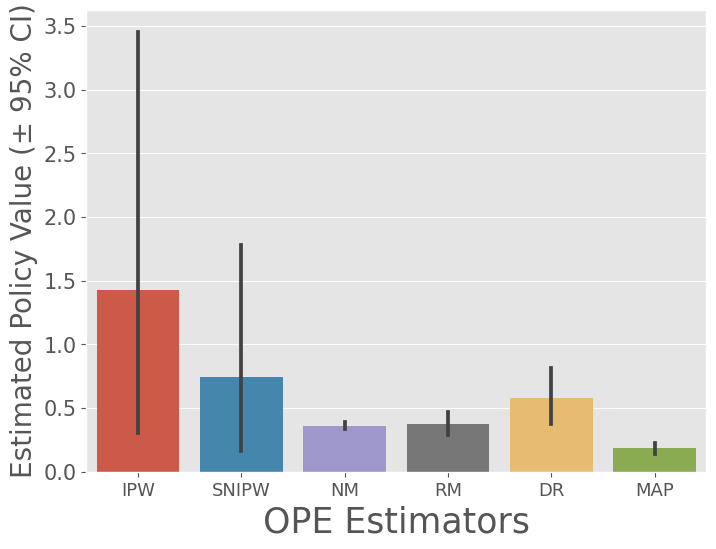

In [10]:
# (3) Off-Policy Evaluation
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=LogisticRegression(),
)
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback["context"],
    action=bandit_feedback["action"],
    reward=bandit_feedback["reward"],
)
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback,
    ope_estimators=[IPW(), SNIP(), NW(), RM(), DR(), MAP()]
)

print(ope.estimate_policy_values(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model  # needed for DM $ DR estomator
    ))

ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
)

print(ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(bandit_feedback['expected_reward'], action_dist=action_dist),
    action_dist = action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
))

In [11]:
dataset.calc_ground_truth_policy_value(bandit_feedback['expected_reward'], action_dist=action_dist)

0.47021848073607064

In [12]:
class Policy:
    
    def __init__(self, n_actions, model=None, bandit_feedback=None, beta=1, len_list=1, random_state=42):
        self.n_actions = n_actions
        self.model = model
        self.bandit_feedback = bandit_feedback
        self.beta = beta
        self.len_list = len_list
        self.random_state = random_state
    
    def predict(self, context: np.ndarray) -> np.ndarray:
        """Predict best actions for new data.

        Note
        --------
        Action set predicted by this `predict` method can contain duplicate items.
        If a non-repetitive action set is needed, please use the `sample_action` method.

        Parameters
        -----------
        context: array-like, shape (n_rounds_of_new_data, dim_context)
            Context vectors for new data.

        Returns
        -----------
        action_dist: array-like, shape (n_rounds_of_new_data, n_actions, len_list)
            Action choices made by a classifier, which can contain duplicate items.
            If a non-repetitive action set is needed, please use the `sample_action` method.

        """
        check_array(array=context, name="context", expected_dim=2)

        action_dist = self.predict_proba(context)

        action_dist_deterministic = np.zeros(action_dist.shape)
        action_dist_deterministic[np.arange(action_dist.shape[0]), np.argmax(action_dist, axis=1).flatten(), 0] = 1
        return action_dist_deterministic
    
    def sample(self, context):
        check_array(array=context, name="context", expected_dim=2)

        action_dist = self.predict_proba(context)
        actions = sample_action_fast(action_dist[:,:,0], self.random_state)

        action_dist_deterministic = np.zeros(action_dist.shape)
        action_dist_deterministic[np.arange(action_dist.shape[0]), actions, 0] = 1
        return action_dist_deterministic


    def predict_score(self, context: np.ndarray) -> np.ndarray:
        """Predict non-negative scores for all possible pairs of actions and positions.

        Parameters
        -----------
        context: array-like, shape (n_rounds_of_new_data, dim_context)
            Context vectors for new data.

        Returns
        -----------
        score_predicted: array-like, shape (n_rounds_of_new_data, n_actions, len_list)
            Scores for all possible pairs of actions and positions predicted by a classifier.

        """
        check_array(array=context, name="context", expected_dim=2)

        n = context.shape[0]
        score_predicted = np.zeros((n, self.n_actions, self.len_list))
        for p in np.arange(self.len_list):
            if self.model is not None:
                score_predicteds_at_position = self.model.predict_proba(
                    context
                )[:,:,p]
            else:
                score_predicteds_at_position = self.bandit_feedback['expected_reward']
            score_predicted[:, :, p] = score_predicteds_at_position
        return score_predicted * self.beta
    
    def predict_proba(
        self,
        context: np.ndarray,
        action_context=None,
        random_state=None,
        tau: Union[int, float] = 1.0,
    ) -> np.ndarray:
        """Obtains action choice probabilities for new data based on scores predicted by a classifier.

        Note
        --------
        This `predict_proba` method obtains action choice probabilities for new data :math:`x \\in \\mathcal{X}`
        by applying the softmax function as follows:

        .. math::

            P (A = a | x) = \\frac{\\mathrm{exp}(f(x,a) / \\tau)}{\\sum_{a^{\\prime} \\in \\mathcal{A}} \\mathrm{exp}(f(x,a^{\\prime}) / \\tau)},

        where :math:`A` is a random variable representing an action, and :math:`\\tau` is a temperature hyperparameter.
        :math:`f: \\mathcal{X} \\times \\mathcal{A} \\rightarrow \\mathbb{R}_{+}`
        is a scoring function which is now implemented in the `predict_score` method.

        **Note that this method can be used only when `len_list=1`, please use the `sample_action` method otherwise.**

        Parameters
        ----------------
        context: array-like, shape (n_rounds_of_new_data, dim_context)
            Context vectors for new data.

        tau: int or float, default=1.0
            A temperature parameter that controls the randomness of the action choice
            by scaling the scores before applying softmax.
            As :math:`\\tau \\rightarrow \\infty`, the algorithm will select arms uniformly at random.

        Returns
        -----------
        choice_prob: array-like, shape (n_rounds_of_new_data, n_actions, len_list)
            Action choice probabilities obtained by a trained classifier.

        """
        assert (
            self.len_list == 1
        ), "predict_proba method cannot be used when `len_list != 1`"
        check_array(array=context, name="context", expected_dim=2)
        check_scalar(tau, name="tau", target_type=(int, float), min_val=0)

        score_predicted = self.predict_score(context=context)
        choice_prob = scipy.special.softmax(score_predicted / tau, axis=1)
        return choice_prob #[:,:,0]

In [21]:
policy = Policy(n_actions=dataset.n_actions, model=None, bandit_feedback=bandit_feedback, beta=-1)
a = policy.predict_proba(bandit_feedback['context'])

In [14]:
print(dataset.calc_ground_truth_policy_value(bandit_feedback['expected_reward'], action_dist=a))
print(ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(bandit_feedback['expected_reward'], action_dist=a),
    action_dist = a,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
))

print(ope.estimate_policy_values(
    action_dist=a,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model  # needed for DM $ DR estomator
    ))

0.6010797273093342
             se
ipw    0.048252
snipw  0.013410
nm     0.057638
rm     0.361297
dr     0.052809
map    0.361297
{'ipw': 0.3814160708821897, 'snipw': 0.4852763754136072, 'nm': 0.361, 'rm': 0.0, 'dr': 0.3712776130619213, 'map': 0.0}


In [15]:
gts = []
vals = []
betas = [-100, -50, -10, -5, -1, 0, 1, 5, 10, 50, 100]
for beta in betas:
    policy = Policy(n_actions=dataset.n_actions, model=None, bandit_feedback=bandit_feedback, beta=beta)
    a = policy.sample(bandit_feedback['context'])

    gt = dataset.calc_ground_truth_policy_value(bandit_feedback['expected_reward'], action_dist=a)
    gts.append(gt)

    val = ope.estimate_policy_values(
        action_dist=a,
        estimated_rewards_by_reg_model=estimated_rewards_by_reg_model  # needed for DM $ DR estomator
        )
    vals.append(val)

df = pd.DataFrame(vals)
df['gt'] = gts
df['beta'] = betas
df

,ipw,snipw,nm,rm,dr,map,gt,beta
0,0.372336,0.365803,0.361,0.329451,0.351067,0.548476,0.351073,-100
1,0.358194,0.355531,0.361,0.328744,0.349067,0.529086,0.354430,-50
2,0.368511,0.417375,0.361,0.363636,0.426084,0.398892,0.403408,-10
3,0.396978,0.476816,0.361,0.357143,0.417750,0.263158,0.467649,-5
4,0.204764,0.285435,0.361,0.353846,0.294140,0.127424,0.605645,-1
5,0.187758,0.373064,0.361,0.303571,0.336268,0.094183,0.644089,0
6,0.151092,0.381964,0.361,0.337500,0.372696,0.074792,0.685893,1
7,0.109313,0.705096,0.361,0.461538,0.401134,0.033241,0.799681,5
8,0.049315,0.757709,0.361,0.600000,0.376329,0.016620,0.850148,10
9,0.015468,1.000000,0.361,1.000000,0.385346,0.002770,0.891879,50


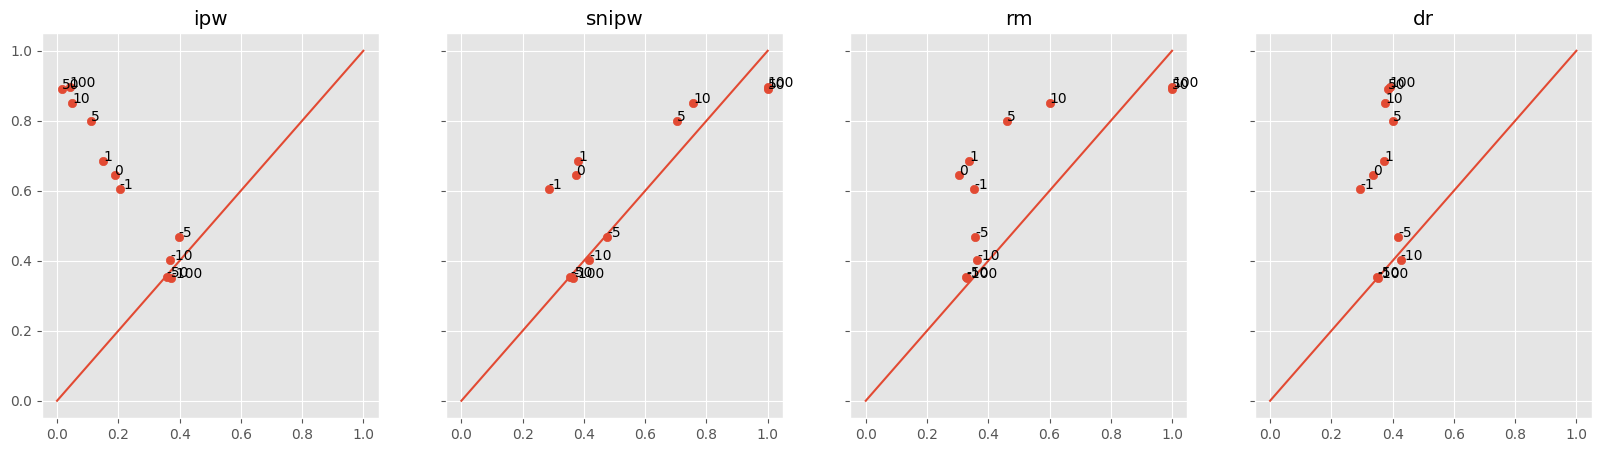

In [16]:
estimators = ['ipw', 'snipw', 'rm', 'dr']
sub_size = (5, 5)
ncols = 4
nrows = int(np.ceil(len(estimators) / ncols))
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex=True, sharey = True, figsize=(sub_size[0]*ncols, sub_size[1]*nrows))

for i, est in enumerate(estimators):
    r = i // ncols
    c = i % ncols

    x = df[est].to_list()
    y = df['gt'].to_list()

    ax = axes[c] if nrows == 1 else axes[r][c]

    ax.scatter(x, y)
    ax.plot([0,1], [0,1])
    ax.set_title(est)

    for i, txt in enumerate(betas):
        ax.annotate(txt, (x[i], y[i]))

In [17]:
# plt.hist(bandit_feedback['action'], bins=dataset.n_actions)

In [18]:
# dataset_test = deepcopy(dataset)
# dataset_test.behavior_policy_function = policy.predict_proba
# dataset_test.beta = 10000
# bandit_feedback_test = dataset_test.obtain_batch_bandit_feedback(n_rounds=10000)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator

isinstance(LogisticRegression(), BaseEstimator)

True